In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from lataq.models import EMBEDCVAE
from lataq_reproduce.exp_dict import EXPERIMENT_INFO
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.dpi'] = 600

In [3]:
results_df = pd.read_pickle('./../benchmarks/benchmarks_new_fixed.pkl')

In [4]:
results_df['method'] = results_df['method'].astype('category')
results_df['method'] = results_df['method'].cat.rename_categories(
    {
        'embedcvae': 'LATAQ',
        'lataq_noland': 'LATAQ - land',
        'tranvae': 'trVAE + land',
        'scanvi': 'scanVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat',
        'symphony': 'Symphony'
    }
)

In [5]:
integration_methods = ['scanVI', 'scVI', 'Seurat', 'Symphony', 'trVAE + land', 'LATAQ', 'LATAQ - land']
classification_methods = ['scanVI', 'Seurat', 'SVM', 'MARS', 'trVAE + land', 'LATAQ']

In [6]:
results_df['integration_scores_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
    'result.graph_conn',
]].mean(axis=1)

In [7]:
results_melt = pd.melt(results_df, id_vars = ['config.data', 'method'])
results_melt = results_melt[~results_melt['variable'].str.contains('time')]
results_melt['method'] = results_melt['method'].astype('category')
results_melt['method'] = results_melt['method'].cat.reorder_categories(
    [
        'LATAQ',
        'LATAQ - land',
        'trVAE + land',
        'scVI',
        'scanVI',
        'MARS',
        'Seurat',
        'Symphony',
        'SVM'
    ]
)

In [8]:
results_melt

,config.data,method,variable,value
108,pancreas,scanVI,result.NMI_cluster/label,0.925007
109,pbmc,scanVI,result.NMI_cluster/label,0.886107
110,brain,scanVI,result.NMI_cluster/label,0.711047
111,scvelo,scanVI,result.NMI_cluster/label,0.612339
112,tumor,scanVI,result.NMI_cluster/label,0.474573
...,...,...,...,...
697,pbmc,Symphony,integration_scores_mean,0.751475
698,scvelo,Symphony,integration_scores_mean,0.542324
699,lung,Symphony,integration_scores_mean,0.613099
700,tumor,Symphony,integration_scores_mean,0.546327


In [9]:
results_melt.groupby(['method', 'variable']).mean()

value
method variable                                  
LATAQ  integration_scores_mean           0.705037
       result.ARI_cluster/label          0.651794
       result.ASW_label                  0.748229
       result.ASW_label/batch            0.750635
       result.NMI_cluster/label          0.781664
...                                           ...
SVM    result.f1-score-macro             0.732632
       result.f1-score-weighted          0.795340
       result.graph_conn                      NaN
       result.isolated_label_F1               NaN
       result.isolated_label_silhouette       NaN

[99 rows x 1 columns]

In [18]:
palette_dict = {
    'LATAQ': '#8E44AD',
    'LATAQ - land': '#ab6cc6',
    'trVAE + land': '#BB8FCE',
    'scVI': '#3498DB',
    'scanVI': '#85C1E9',
    'MARS': '#616A6B',
    'Seurat': '#CB4335',
    'Symphony': '#F1948A',
    'SVM': '#F7DC6F'
}

In [26]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'integration_scores_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('Integration scores mean')
ax.set_ylabel('Score')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 0.85])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

<ipython-input-26-c2ccc578e6e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [27]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-macro')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Macro')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_f1macro.png', dpi=600, bbox_inches='tight')

<ipython-input-27-cb2c06f883a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [28]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-weighted')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Weighted')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_f1weighted.png', dpi=600, bbox_inches='tight')

<ipython-input-28-475a3395e261>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [29]:
df_plot = results_melt.pivot(index=['config.data', 'method'], values='value', columns='variable').reset_index()
df_plot = df_plot[df_plot['method'].isin(['LATAQ', 'trVAE + land','scanVI', 'Seurat'])]
df_plot['method'] = df_plot['method'].astype('category').cat.remove_unused_categories()
df_mean = df_plot.groupby('method').mean()
df_std = df_plot.groupby('method').std()
df_bottom = df_plot.groupby('method').quantile(0.05)
df_bottom = df_mean - df_bottom
df_top = df_plot.groupby('method').quantile(0.95)
df_top = df_top - df_mean

In [30]:
df_mean

variable,integration_scores_mean,result.ARI_cluster/label,result.ASW_label,result.ASW_label/batch,result.NMI_cluster/label,result.PCR_batch,result.f1-score-macro,result.f1-score-weighted,result.graph_conn,result.isolated_label_F1,result.isolated_label_silhouette
method,,,,,,,,,,,
LATAQ,0.705037,0.651794,0.748229,0.750635,0.781664,0.350445,0.626485,0.754200,0.966427,0.715536,0.675567
trVAE + land,0.705225,0.690841,0.717192,0.788221,0.795590,0.345991,0.644540,0.745917,0.959843,0.661804,0.682315
scanVI,0.668134,0.633449,0.589538,0.843314,0.731906,0.253095,0.506257,0.710112,0.966959,0.732638,0.594172
Seurat,0.646691,0.592544,0.565028,0.865436,0.689035,0.286913,0.637115,0.736303,0.972280,0.599296,0.602999


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


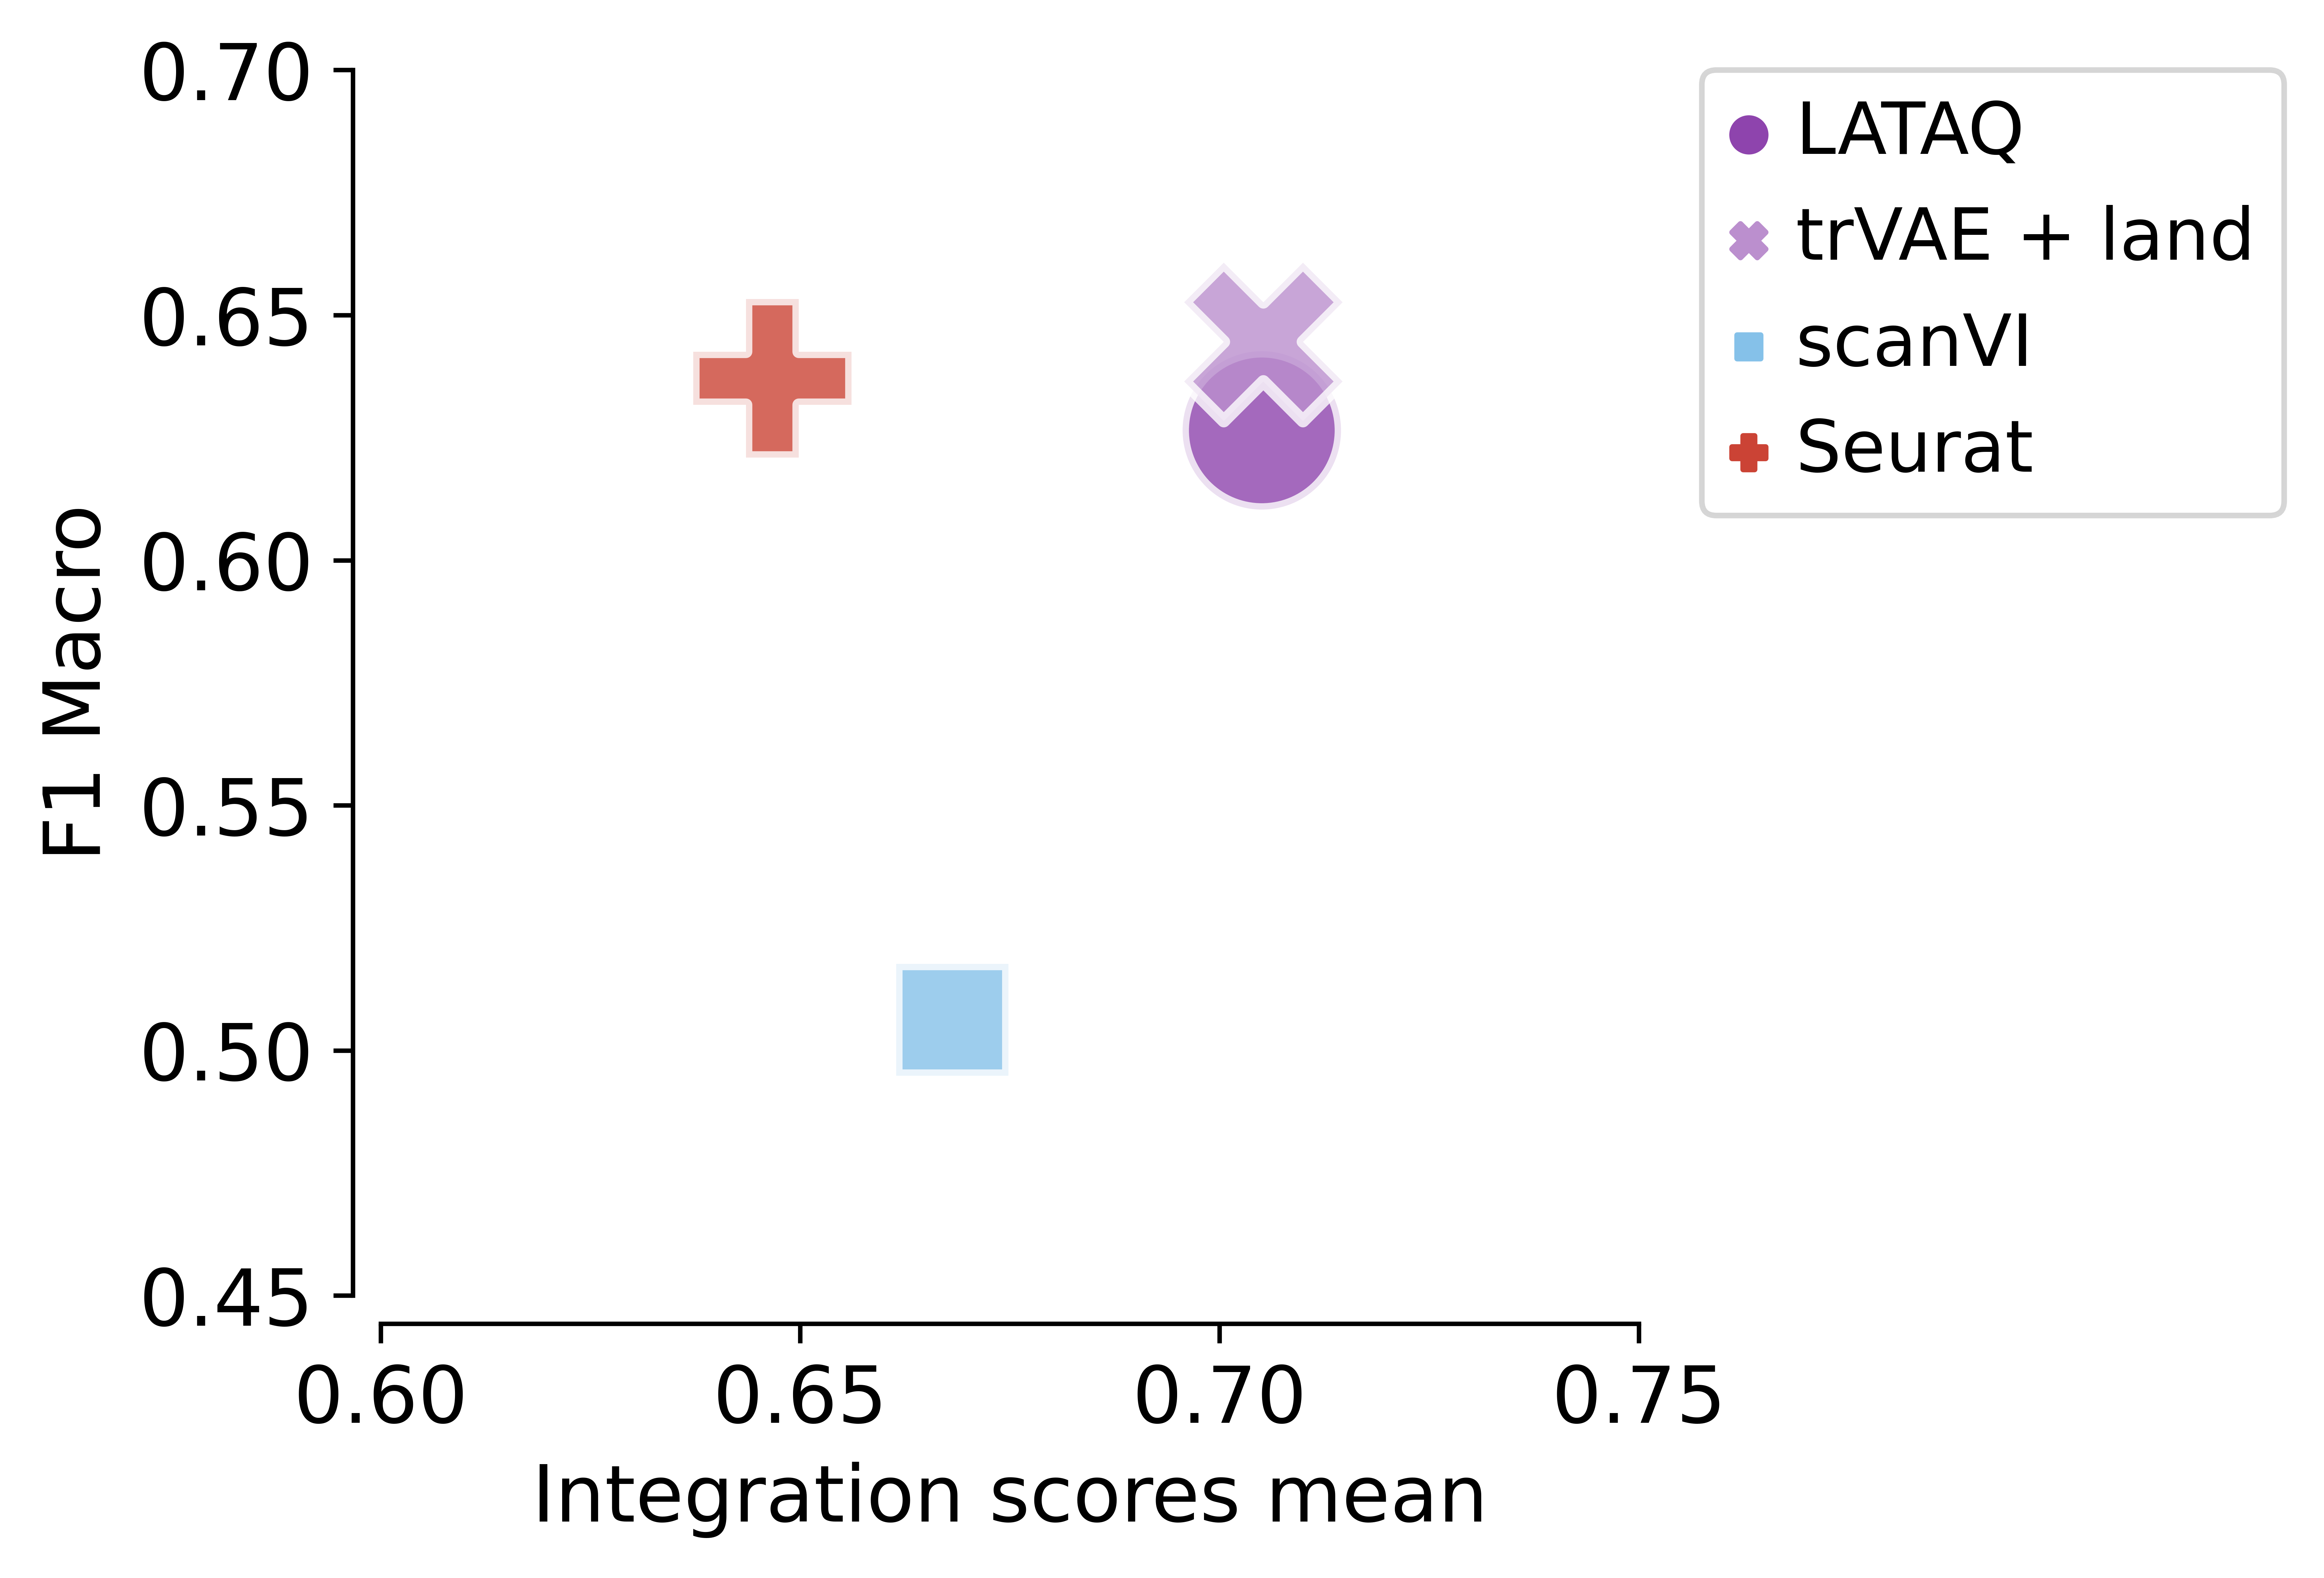

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-macro'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Macro')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.45, 0.7])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1macro.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


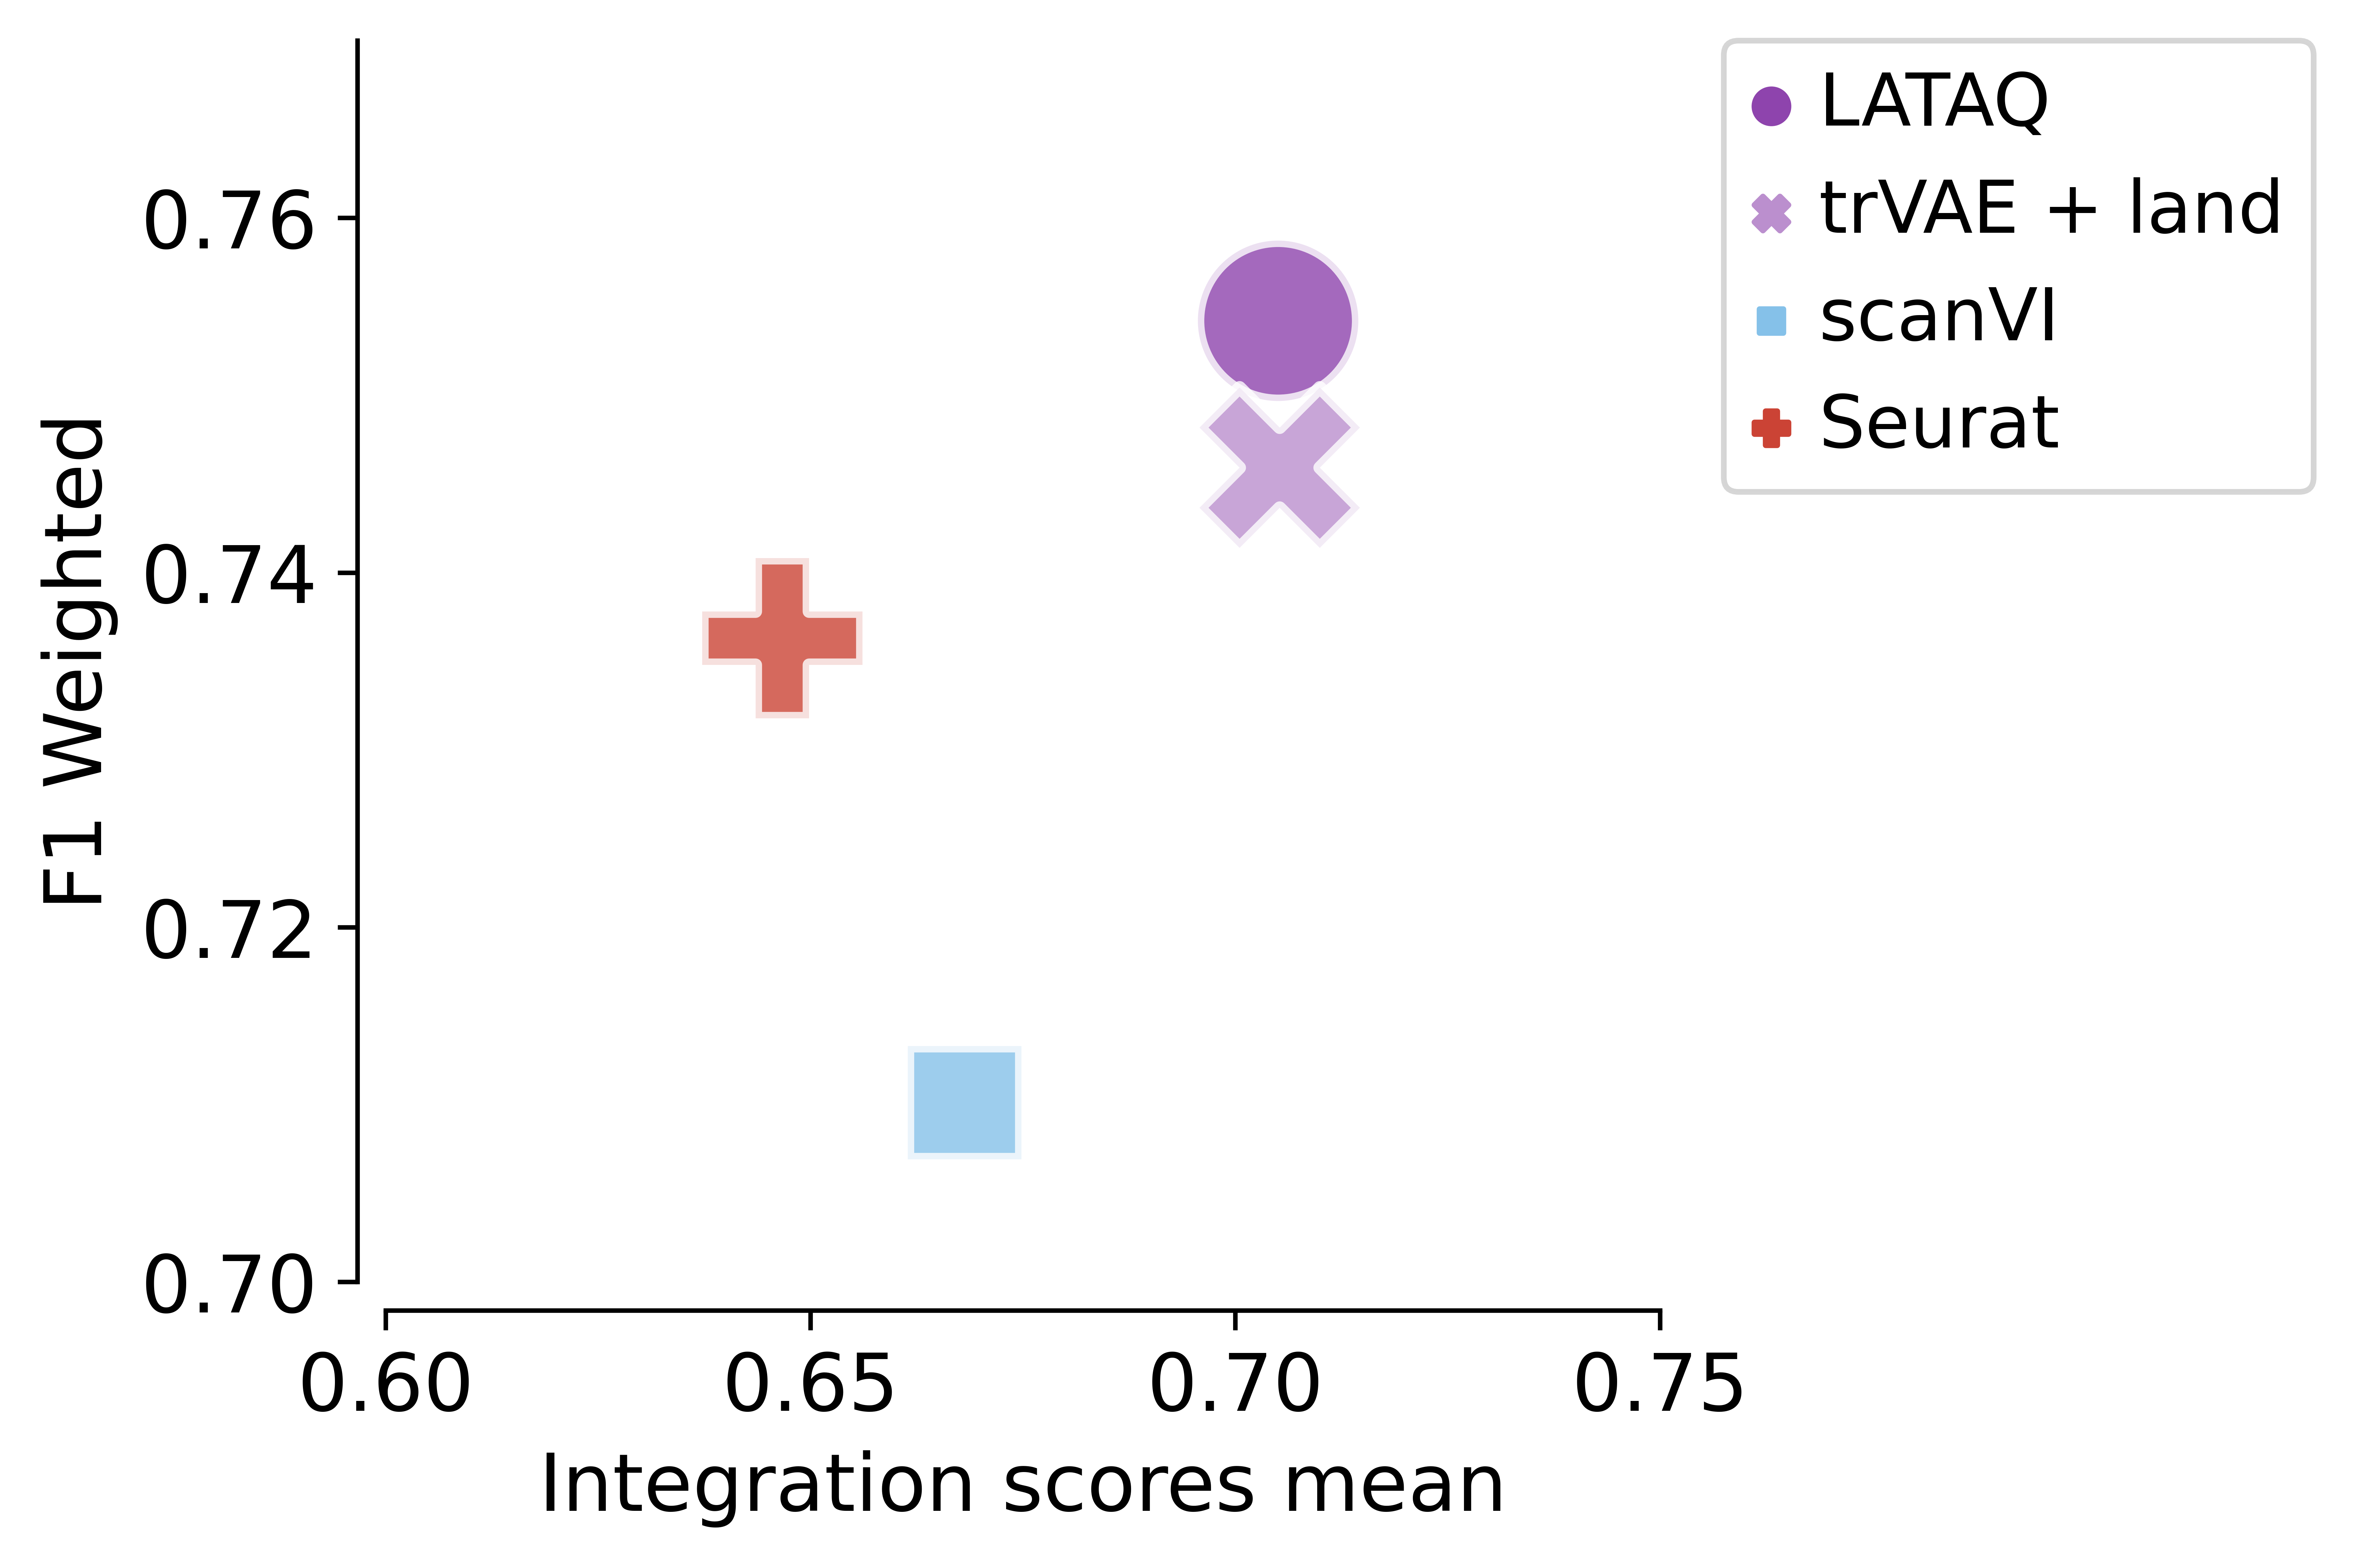

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-weighted'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Weighted')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.7, 0.77])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1weighted.png', dpi=600, bbox_inches='tight')